In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
sns.set_palette(palette = "hls", desat = 1)# n_colors = 3,

In [2]:
df = pd.read_csv('results.csv', index_col="Unnamed: 0")  # TODO eliminate all unused columns
df.shape

(69, 88)

### Influence of one variable into another

In [ ]:
# Quantitative dependent metrics
PB_quantitative = [
    "Sentences read prior guess",
    "Sentences read",
    "Sentences read post guess",
    "Prosocial behaviour time [min]"
]

# Qualitative dependent metrics
PB_qualitative = [
    "Caring [1-7]",
    "Likeable [1-7]",
    "Empathetic [1-7]",
    "Do you think the manner the robot addressed the object influenced how much time you spent helping it?"
]

# Quantitative dependent metrics
PT_quantitative = [
    "Total mistakes",
    "Perspective taking task time [min]",
    "Total scanning time [min]"
]

# Qualitative dependent metrics
PT_qualitative = [
    "Gender",
    "Age",
    "Need for collecting data [1-7]",
    "Instructions easy to follow [1-7]"
]

# Interpersonal Reactivity Index (??)
IRI = [
    "Perspective-Taking Scale",
    "Empathic Concern Scale",
    "Fantasy Scale"
]

In [ ]:
g = sns.lmplot(
    x="Empathic Concern Scale",
    y="Do you think the manner the robot addressed the object influenced how much time you spent helping it?",
    hue='Condition',
    data=df.fillna(1),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylabel="Participants rating from 1 to 7")
g.set(ylim=(0.5, 7.5))
plt.savefig(f"figures/Empathic Concern scale on influence.pdf",bbox_inches='tight')

In [ ]:
g = sns.lmplot(
    x="Perspective-Taking Scale",
    y="Do you think the manner the robot addressed the object influenced how much time you spent helping it?",
    hue='Condition',
    data=df.fillna(1),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylabel="Participants rating from 1 to 7")
g.set(ylim=(0.5, 7.5))
plt.savefig(f"figures/PT scale on influence.pdf",bbox_inches='tight')

In [ ]:
g = sns.lmplot(
    x="Instructions easy to follow [1-7]",
    y="Sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylim=(0, None))
plt.savefig(f"figures/Instruction difficulty on sentences read.pdf",bbox_inches='tight')

In [ ]:
g = sns.lmplot(
    x="Need for collecting data [1-7]",
    y="Sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylim=(0, None))
plt.savefig(f"figures/Need data on sentences read.pdf",bbox_inches='tight')

In [ ]:
g = sns.lmplot(
    x="Perspective taking task time [min]",
    y="Sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylim=(0, None))

plt.savefig(f"figures/PT time on sentences read.pdf",bbox_inches='tight')

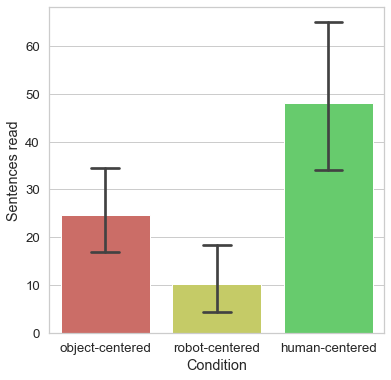

In [44]:
plt.figure(figsize=(6.0, 6.0))
g = sns.barplot(
    data=df.fillna(0),
    x="Condition",
    y="Sentences read",
    order = ["object-centered","robot-centered","human-centered"],
    capsize = 0.25
)
plt.savefig("figures/PT time on sentences read histogram.pdf",bbox_inches='tight')  

### Heat map: conditoin versus reverse condition

Create a CMAP from a discret pallet, highlightning the transition red -> yellow representing the small values. Why? Because in the heatmap, the total column has high values, and by increasing the contrast before in the continous scale, I'm adding more contrast in on the heatmap per se.

In [24]:
from matplotlib.colors import ListedColormap

colorarray = list(sns.hls_palette()[:3])
increment = [[colorarray[1][0]-colorarray[0][0], colorarray[1][1]-colorarray[0][1], colorarray[1][2]-colorarray[0][2]],[colorarray[2][0]-colorarray[1][0], colorarray[2][1]-colorarray[1][1], colorarray[2][2]-colorarray[1][2]]]
threshold = 33.0    # to control each increment is more significative in the continuous map
for i in range(98):
    if i < threshold: colorarray.insert(i+1,[colorarray[i][j]+increment[0][j]/threshold for j in range(3)]) # between red and yellow
    else: colorarray.insert(i+2,[colorarray[i+1][j]+increment[1][j]/(98-threshold) for j in range(3)]) # between yellow and green

cmap = ListedColormap(colorarray)

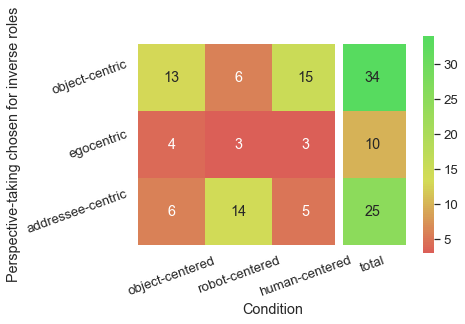

In [25]:
df_aux = df[["Condition", "If you were to tell the robot to pick up the objects how would you do it?"]].value_counts().copy()
df_heatmap = pd.DataFrame(columns=['Condition', 'Perspective-taking chosen for inverse roles', 'Occurrences'], dtype="float")
for condition_pair, occupance, in df_aux.iteritems():
    ideal_condition = "addressee-centric" if "your" in condition_pair[1] else "egocentric" if "my" in condition_pair[1] else "object-centric"
    df_heatmap = df_heatmap.append({
        'Condition': condition_pair[0],
        'Perspective-taking chosen for inverse roles': ideal_condition,
        'Occurrences': occupance},
        ignore_index=True)

total = df_heatmap[["Perspective-taking chosen for inverse roles", "Occurrences"]].groupby("Perspective-taking chosen for inverse roles").sum().to_dict()["Occurrences"]
for key, value in total.items():
    df_heatmap = df_heatmap.append({
        'Condition': "total",
        'Perspective-taking chosen for inverse roles': key,
        'Occurrences': value},
        ignore_index=True)

df_heatmap = df_heatmap.pivot("Perspective-taking chosen for inverse roles", "Condition", "Occurrences")
# sorting
df_heatmap = df_heatmap[["object-centered", "robot-centered", "human-centered","total"]]
df_heatmap = df_heatmap.reindex(["object-centric", "egocentric", "addressee-centric"])

ax = sns.heatmap(df_heatmap, annot=True, cmap = cmap, square="True")
ax.axvline(3, color='white', lw=8)
plt.yticks(rotation=20)
plt.xticks(rotation=20)
plt.savefig(f"figures/Condition_chosen_for_inverse_roles.pdf",bbox_inches='tight')